In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import os
import random
import psycopg2
import json

np.random.seed(42)

In [33]:

@jit(nopython=True)
def simulate_numba(num_steps, k_e_square, W_e, L_e_plus, W_plus, L_plus_e, eta_batch, dt, epsilon, r_m, k_plus_square):
    phi_e = np.array([0.0, 0.0])
    phi_plus = np.array([0.0, 0.0])
    U = 0.01
    
    phi_e_history = np.zeros((num_steps, 2))
    phi_plus_history = np.zeros((num_steps, 2))
    U_history = np.zeros(num_steps)
    R_vals = np.zeros(num_steps)
    k_e_psi_e_vals = np.zeros(num_steps)
    k_e_b_e_vals = np.zeros(num_steps)
    k_e_psi_plus_vals = np.zeros(num_steps)
    k_e_b_plus_vals = np.zeros(num_steps)
    heat_flux_psi_e_b_e_vals = np.zeros(num_steps)
    heat_flux_psi_e_b_plus_vals = np.zeros(num_steps)
    b_e_psi_plus_vals = np.zeros(num_steps)
    b_e_b_plus_vals = np.zeros(num_steps)
    psi_plus_b_plus_vals = np.zeros(num_steps)

    switch_times = []

    for i in range(num_steps):
        eta = eta_batch[i]
        xi = np.array([2 * np.sqrt(2) * eta[0] / np.sqrt(k_e_square), 0.0])
        phi_e_dot = np.zeros(2)
        phi_plus_dot = np.zeros(2)

        phi_e_dot[0] = W_e[0, 0] * phi_e[0] + W_e[0, 1] * phi_e[1] + U * (
            L_e_plus[0, 0] * phi_plus[0] + L_e_plus[0, 1] * phi_plus[1]) + (np.sqrt(epsilon) * xi[0]) / np.sqrt(dt)
        phi_e_dot[1] = W_e[1, 0] * phi_e[0] + W_e[1, 1] * phi_e[1] + U * (
            L_e_plus[1, 0] * phi_plus[0] + L_e_plus[1, 1] * phi_plus[1]) + (np.sqrt(epsilon) * xi[1]) / np.sqrt(dt)

        phi_plus_dot[0] = W_plus[0, 0] * phi_plus[0] + W_plus[0, 1] * phi_plus[1] + U * (
            L_plus_e[0, 0] * phi_e[0] + L_plus_e[0, 1] * phi_e[1])
        phi_plus_dot[1] = W_plus[1, 0] * phi_plus[0] + W_plus[1, 1] * phi_plus[1] + U * (
            L_plus_e[1, 0] * phi_e[0] + L_plus_e[1, 1] * phi_e[1])

        phi_e[0] += phi_e_dot[0] * dt
        phi_e[1] += phi_e_dot[1] * dt
        phi_plus[0] += phi_plus_dot[0] * dt
        phi_plus[1] += phi_plus_dot[1] * dt

        R = 0.25 * k * (k_plus_square - k_e_square) * phi_e[0] * phi_plus[0]
        U_dot = R - r_m * U
        U += U_dot * dt

        phi_e_history[i, 0] = phi_e[0]
        phi_e_history[i, 1] = phi_e[1]
        phi_plus_history[i, 0] = phi_plus[0]
        phi_plus_history[i, 1] = phi_plus[1]

        psi_e = phi_e[0]
        b_e = phi_e[1]
        psi_plus = phi_plus[0]
        b_plus = phi_plus[1]

        U_history[i] = U
        R_vals[i] = R

        k_e_psi_e_vals[i] = psi_e*psi_e
        k_e_b_e_vals[i] = b_e*b_e
        k_e_psi_plus_vals[i] = psi_plus*psi_plus
        k_e_b_plus_vals[i] = b_plus*b_plus
        heat_flux_psi_e_b_e_vals[i] = psi_e*b_e
        heat_flux_psi_e_b_plus_vals[i] = psi_e*b_plus
        b_e_psi_plus_vals[i] = b_e*psi_plus
        b_e_b_plus_vals[i] = b_e*b_plus
        psi_plus_b_plus_vals[i] = psi_plus*b_plus
        


        if i > 0:
            if U_history[i - 1] > 0 and U_history[i] < 0:
                switch_times.append(i)
    return phi_e_history, phi_plus_history, U_history, R_vals, k_e_psi_e_vals, k_e_b_e_vals, k_e_psi_plus_vals, k_e_b_plus_vals, heat_flux_psi_e_b_e_vals, heat_flux_psi_e_b_plus_vals, b_e_psi_plus_vals, b_e_b_plus_vals, psi_plus_b_plus_vals, switch_times

class Simulation:
    def __init__(self, epsilon, N_0_squared, r_m, k, m, m_u, dt, total_time):
        self.epsilon = epsilon
        self.N_0_squared = N_0_squared
        self.r_m = r_m
        self.k = k
        self.m = m
        self.m_u = m_u
        self.dt = dt
        self.total_time = total_time
        self.num_steps = int(total_time / dt)
        self.k_e_square = k**2 + m**2
        self.k_plus_square = k**2 + (m + m_u)**2
        self.eta_batch = self.generate_eta_batch()
        self.W_e = np.array([[-1, (k / self.k_e_square)], [-k * N_0_squared, -1]])
        self.W_plus = np.array([[-1, -k / self.k_plus_square], [k * N_0_squared, -1]])
        self.L_e_plus = np.array([[(-k / (2 * self.k_e_square)) * (self.k_plus_square - m_u**2), 0],
                                  [0, k / 2]])
        self.L_plus_e = np.array([[(-k / (2 * self.k_plus_square)) * (m_u**2 - self.k_e_square), 0],
                                  [0, -k / 2]])

        self.phi_e_history = np.zeros((self.num_steps, 2))
        self.phi_plus_history = np.zeros((self.num_steps, 2))
        self.U_history = np.zeros(self.num_steps)
        self.R_vals = np.zeros(self.num_steps)
        self.k_e_psi_e_vals = np.zeros(self.num_steps)
        self.k_e_b_e_vals = np.zeros(self.num_steps)
        self.k_e_psi_plus_vals = np.zeros(self.num_steps)
        self.k_e_b_plus_vals = np.zeros(self.num_steps)
        self.heat_flux_psi_e_b_e_vals = np.zeros(self.num_steps)
        self.heat_flux_psi_e_b_plus_vals = np.zeros(self.num_steps)
        self.b_e_psi_plus_vals = np.zeros(self.num_steps)
        self.b_e_b_plus_vals = np.zeros(self.num_steps)
        self.psi_plus_b_plus_vals = np.zeros(self.num_steps)

    def generate_eta_batch(self):
        return np.random.normal(0, 1, size=(self.num_steps, 1))

    def simulate(self):
        self.phi_e_history, self.phi_plus_history, self.U_history, self.R_vals, self.k_e_psi_e_vals, self.k_e_b_e_vals, self.k_e_psi_plus_vals, self.k_e_b_plus_vals, self.heat_flux_psi_e_b_e_vals, self.heat_flux_psi_e_b_plus_vals, self.b_e_psi_plus_vals, self.b_e_b_plus_vals, self.psi_plus_b_plus_vals, self.switch_times = simulate_numba(
            self.num_steps, self.k_e_square, self.W_e, self.L_e_plus, self.W_plus, self.L_plus_e, self.eta_batch, self.dt, self.epsilon, self.r_m, self.k_plus_square)
        
    
    def plot(self):
        time_array = np.arange(0, total_time, self.dt)

        fig, axs = plt.subplots(1, 1, figsize=(12, 8))
        axs.plot(time_array, self.U_history, label='Average', linewidth=1.5, color='blue')
        axs.set_title(f'U Values')
        axs.grid()

In [34]:
if __name__ == "__main__":
    # simulations = []
    epsilon = 0.12394270273516043
    N_0_squared = 318.8640217310387
    r_m = 0.1
    k = 2 * np.pi * 6
    m = 2 * np.pi * 3
    m_u = 2 * np.pi * 7
    # dt = 0.001
    total_time = 200

In [35]:
dt_list = [.01, .001, .0001, .00001]

sim01 = Simulation(epsilon, N_0_squared, r_m, k, m, m_u, dt_list[0], total_time)
sim001 = Simulation(epsilon, N_0_squared, r_m, k, m, m_u, dt_list[1], total_time)
sim0001 = Simulation(epsilon, N_0_squared, r_m, k, m, m_u, dt_list[2], total_time)
sim00001 = Simulation(epsilon, N_0_squared, r_m, k, m, m_u, dt_list[3], total_time)

In [36]:
sim01.simulate()
sim001.simulate()
sim0001.simulate()
sim00001.simulate()

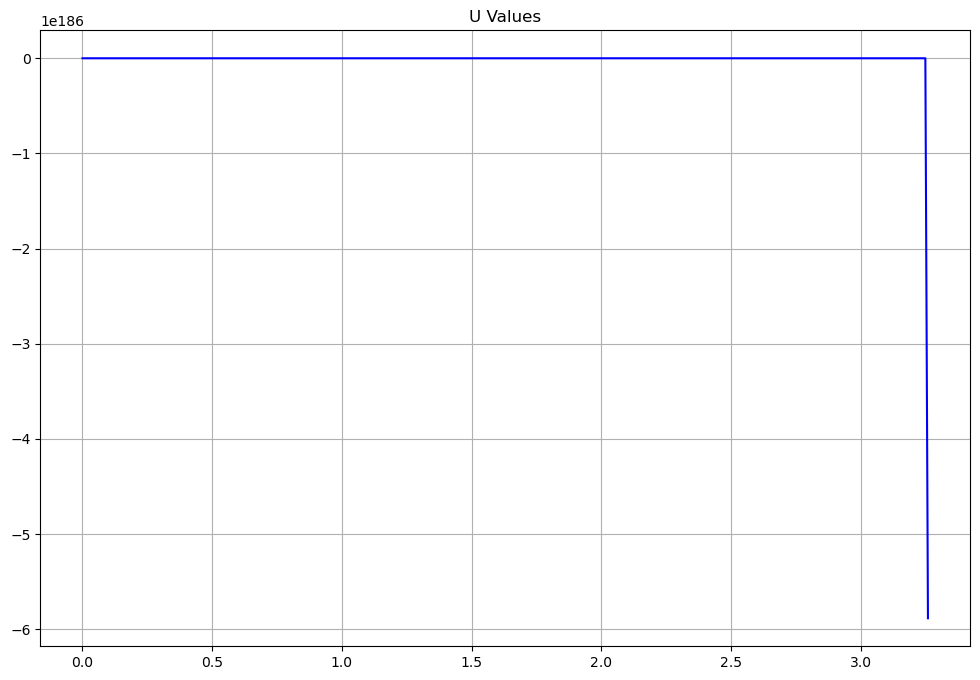

In [37]:
sim01.plot()

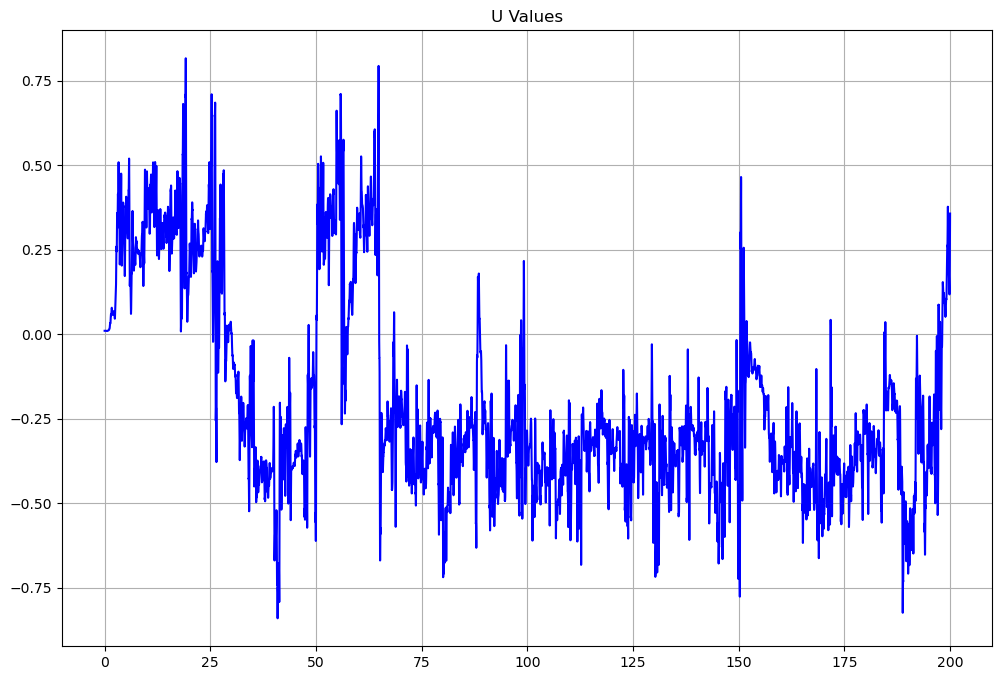

In [38]:
sim001.plot()

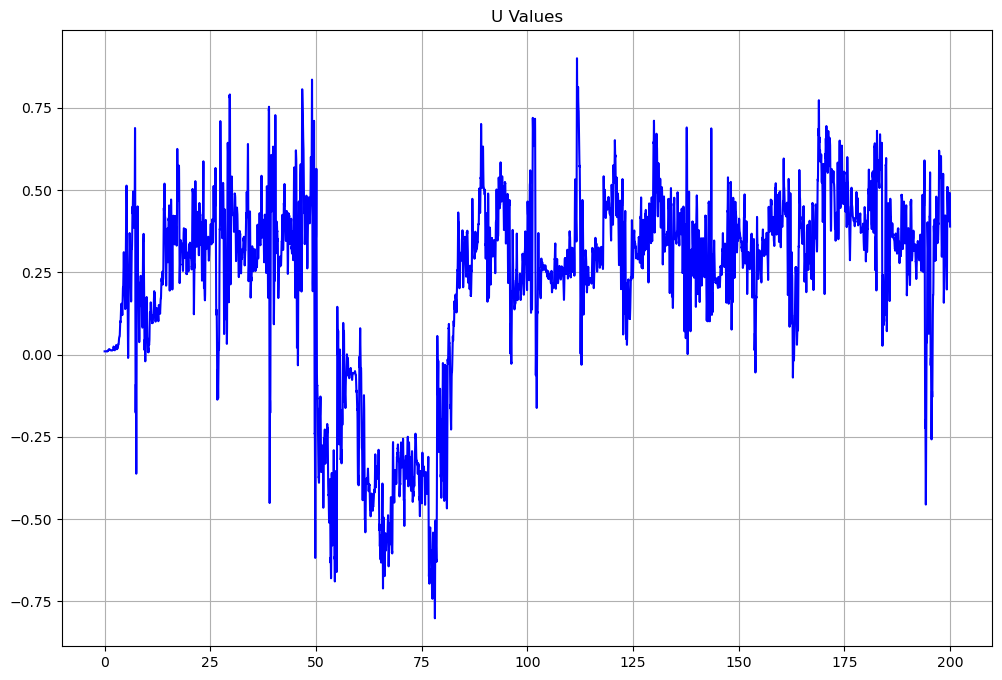

In [39]:
sim0001.plot()

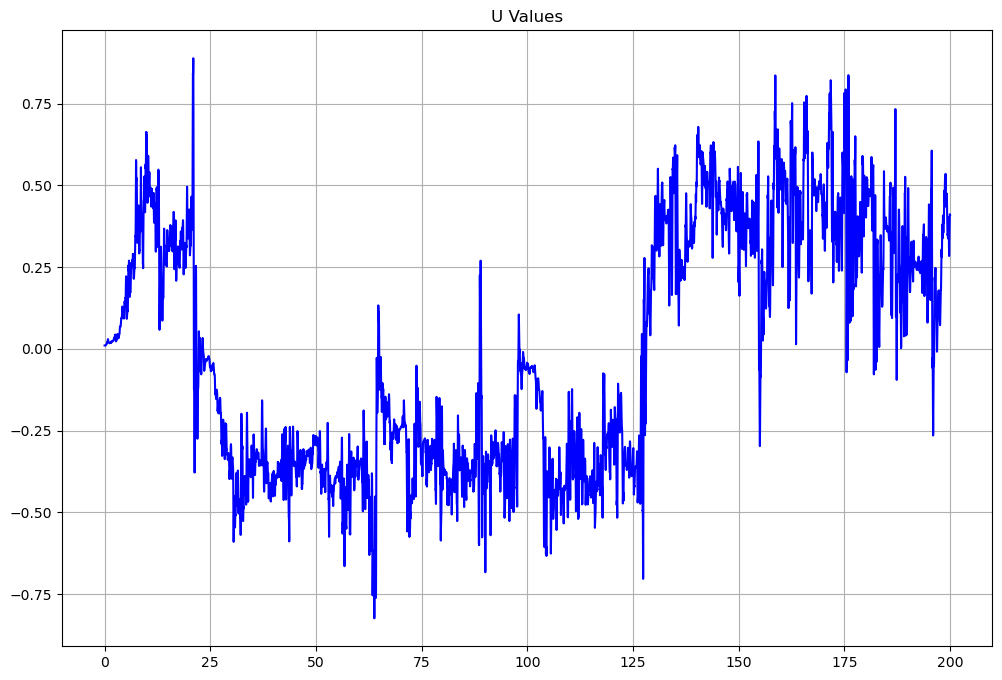

In [40]:
sim00001.plot()